In this notebook we'll try to detect and trace the lines from an aerial image of a sugar cane field.

We proceed first in importing the image.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.io import imread
from skimage.feature import canny, corner_harris, corner_subpix, corner_peaks
from skimage.filters import roberts, sobel, scharr, prewitt, median, gaussian
from skimage import color, draw
import skimage
from skimage.transform import probabilistic_hough_line
from skimage import exposure
from skimage.restoration import (
    denoise_tv_chambolle,
    denoise_bilateral,
    denoise_wavelet,
    estimate_sigma,
)
from skimage import data, img_as_float

plt.rcParams["figure.figsize"] = [15, 5]

EX = "results/2.2.4"

# Import the image
orig = imread("data/Field.jpg")
orig.shape

(1627, 1427, 3)

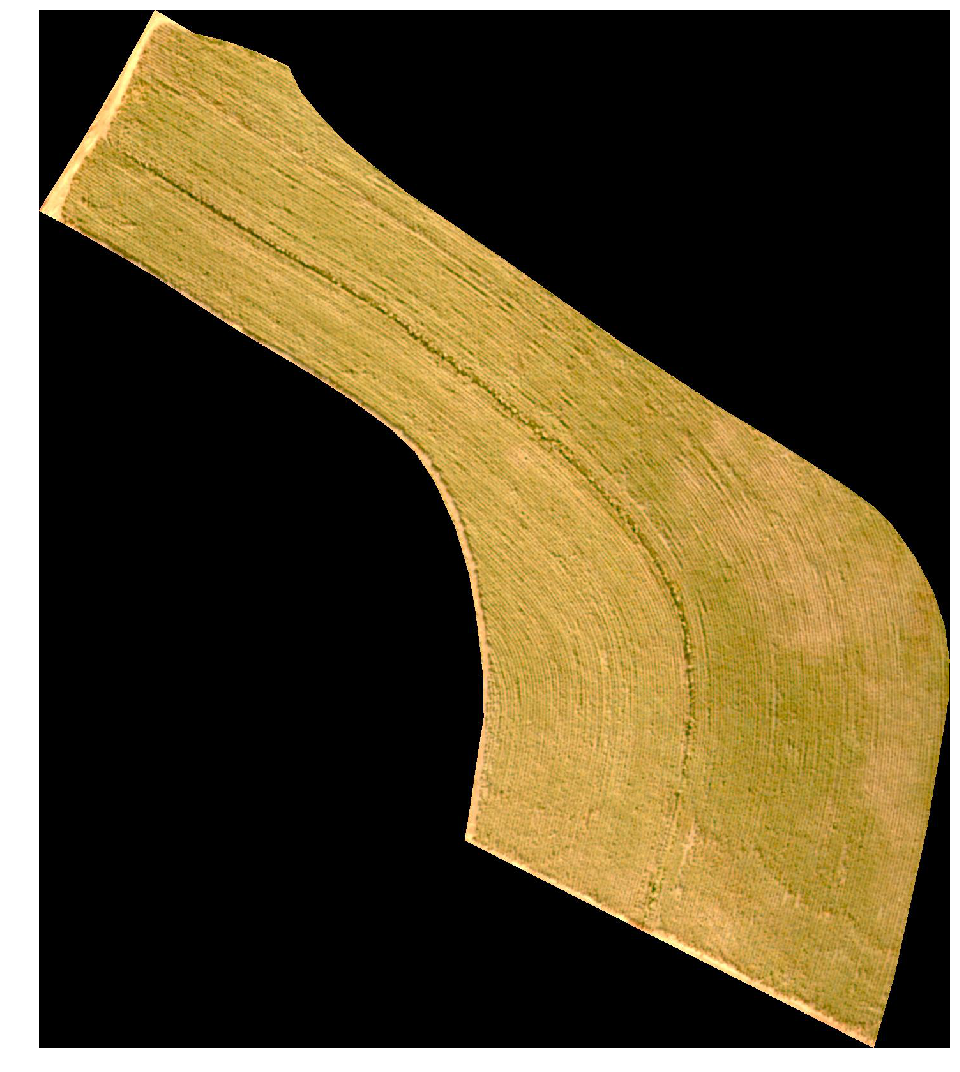

In [3]:
def plot_images(imgs: list, n_rows: int = 1, cm=plt.cm.gray) -> list:
    n_cols = len(imgs) // n_rows
    if len(imgs) % n_rows:
        n_cols += 1
    im_iter = iter(imgs)
    fig = plt.figure(figsize=(15, 15))

    for im, i in zip(im_iter, range(1, n_cols * n_rows + 1)):
        fig.add_subplot(n_rows, n_cols, i)
        plt.imshow(im, cmap=cm)
        plt.axis("off")
        plt.tight_layout()


plot_images([orig])

Let's see the histogram for each color channel

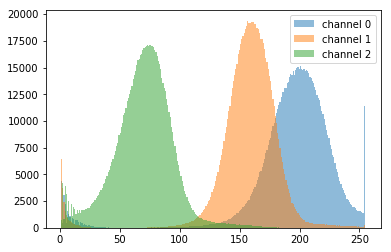

In [4]:
def plot_histogram(img, imtype="rgb"):
    # Split by layers
    if imtype == "lab":
        img = (img + [0, 128, 128]) / [100, 255, 255] * [255, 255, 255]
    layers = cv2.split(img)

    _, ax = plt.subplots(1, 1)

    # Check histogram (ignoring black values)
    for i, l in enumerate(layers):
        _ = ax.hist(l.flatten(), 255, [1, 255], alpha=0.5, label=f"channel {i}")
        ax.legend()


plot_histogram(orig, False)

Channels 0 and 2 are well separated in rgb space. 

The first attempt was to set channel 1 to 0 and keep only the two nicely separated channels. However, I didn't got good results, as expected since yellow color is predominant in the whole image.

This observation made me think to represent the image in a different color space. LAB displays luminosity in the first channel, and seems a good option for this image.  

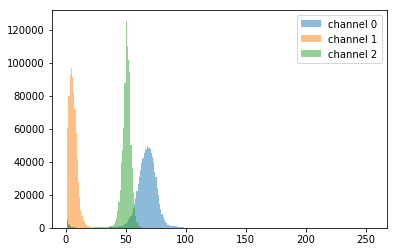

In [5]:
# Converting to lab
lab = skimage.color.rgb2lab(orig)
lab_scaled = (lab + [0, 128, 128]) / [100, 255, 255]

plot_histogram(lab)

Note that channel one has different value range than the others ([0-100] vs [-128, 128]).

The idea here is to filter the image by luminosity to amplify contrasts.
I'll do this by first finding the average of the gaussian and then manually setting a value based on  its std.

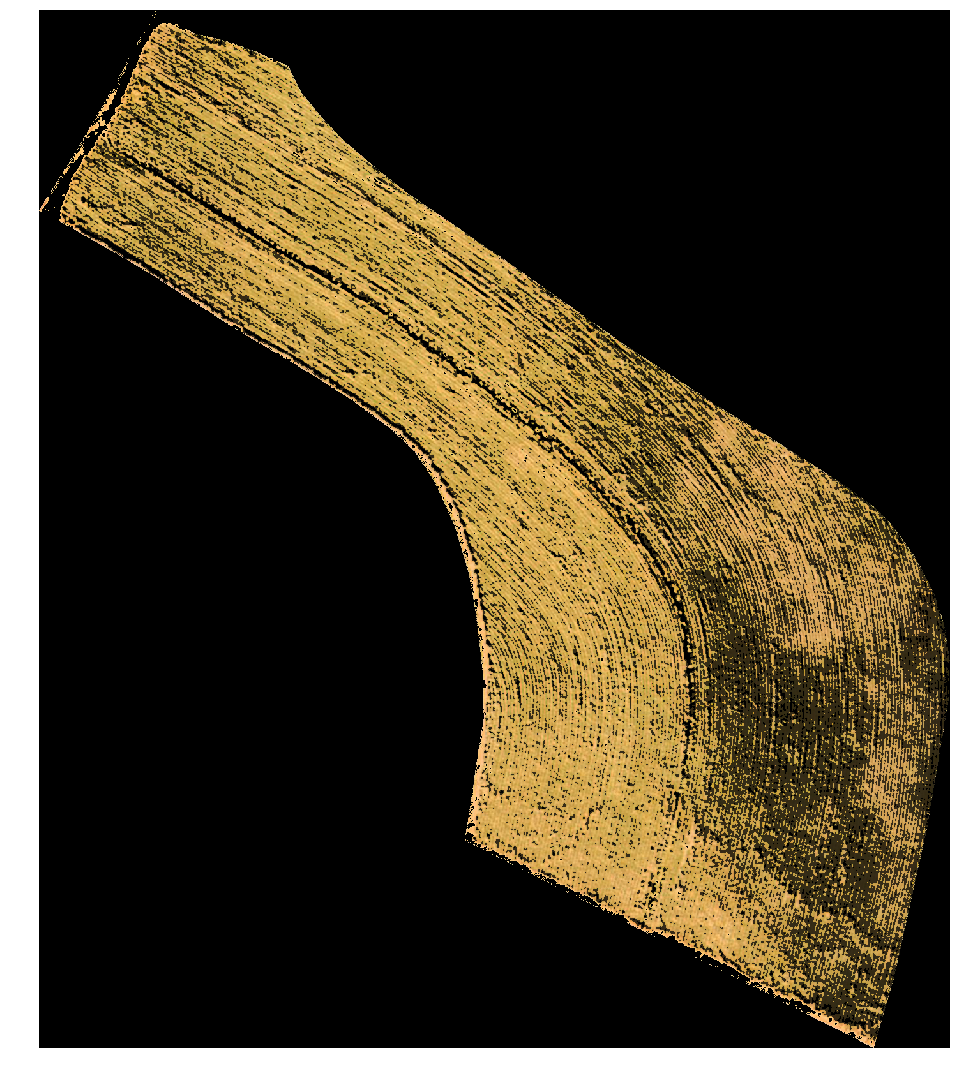

In [6]:
# average luminosity
m = np.mean(lab[:, :, 0])
sd = np.std(lab[:, :, 0])

# thresholding on luminosity
lab[lab[:, :, 0] < m + 0.9 * sd] = 0
lab[lab[:, :, 0] < m + 1.2 * sd] = 0.3 * lab[lab[:, :, 0] < m + 1.2 * sd]
lab[lab[:, :, 0] > m + 1.8 * sd] = 0

# and back
fromlab = skimage.color.lab2rgb(lab)
plot_images([fromlab])

Not bad, the lines are now more contrasted. Let's convert the image to gray for further processing

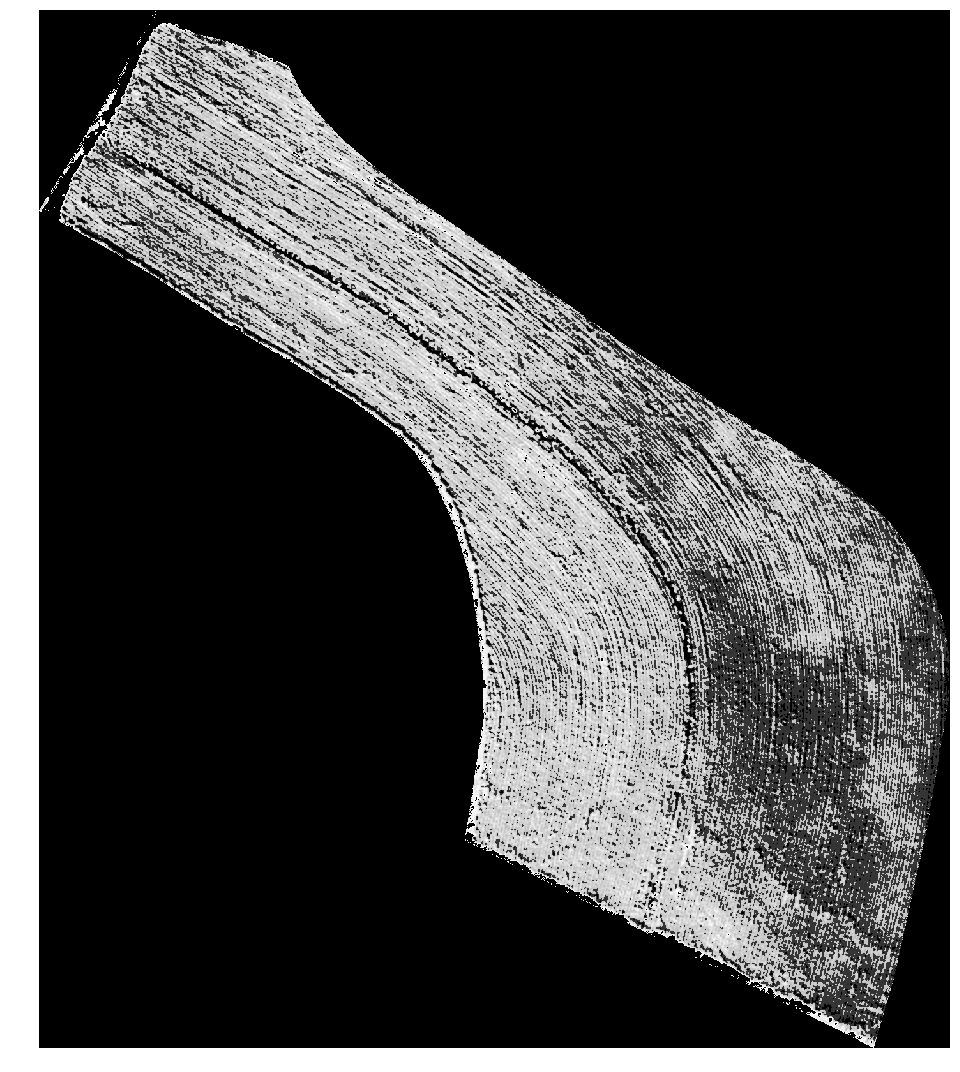

In [7]:
# img = skimage.color.lab2rgb(lab)
gray = skimage.color.rgb2gray(fromlab)

plot_images([gray])

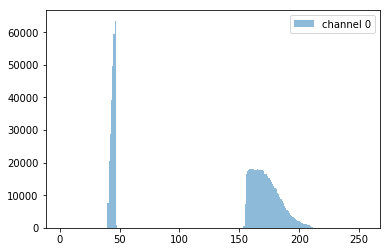

In [8]:
plot_histogram(gray * 255)

The instogram of the gray image suggest that two features are sharply separated (we are not showing the black value here).

We can now proceed in extracting the sugar lines in 2 steps.

First, we smooth and increase the contrast in the image by:

* locally increasing the contrast in the image with Contrast Limited Adaptive Histogram Equalization (CLAHE).
* applying erosion and dilation in sequence to separate and enhance lines
* applying a gaussian an bilateral filter to smooth the pixels

Second, we find the gradients with a a sequence of vertical sobel filters and dilations. 

/Users/irisuky/anaconda3/envs/logmind/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


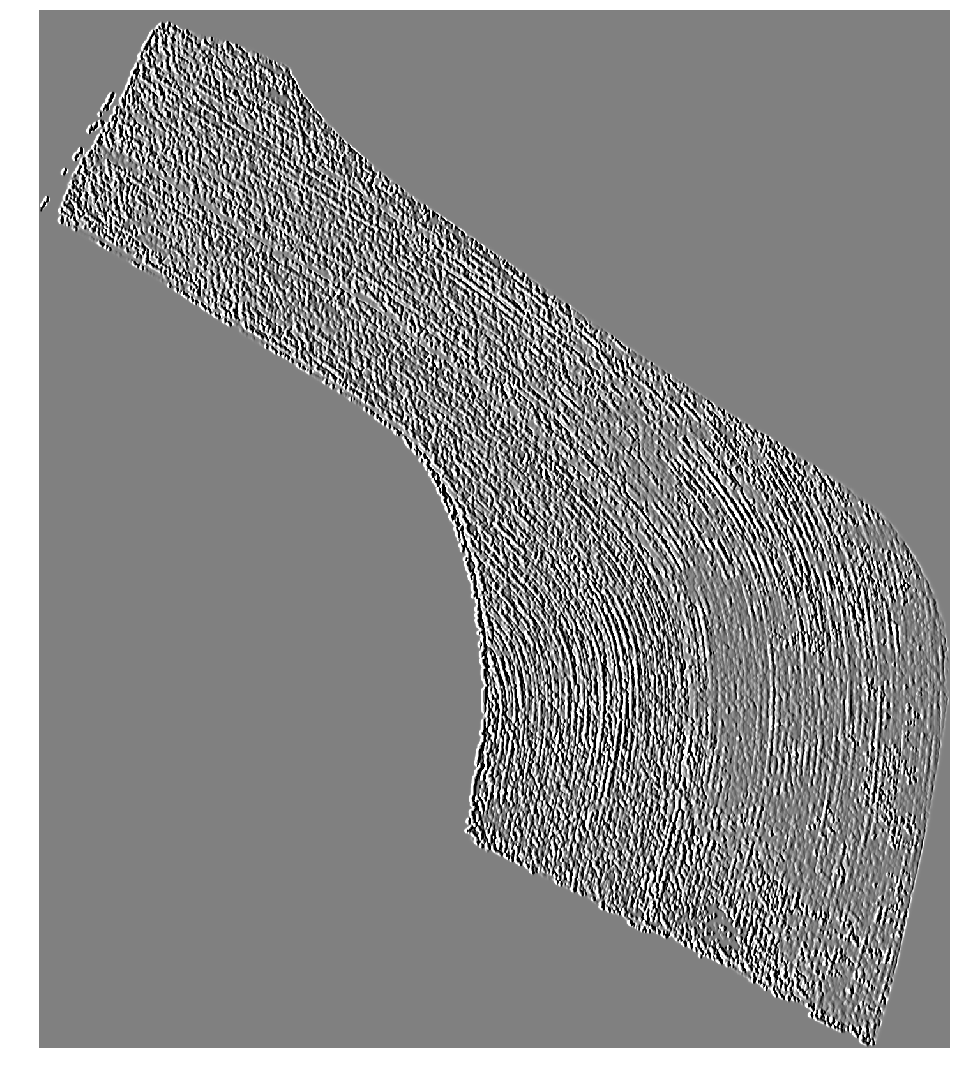

In [9]:
def smooth(img):
    img = skimage.exposure.equalize_adapthist(img, clip_limit=0.03)
    img = denoise_bilateral(
        img, sigma_color=0.15, sigma_spatial=2, multichannel=False
    )
    img = skimage.morphology.erosion(img)
    img = skimage.morphology.opening(img)
    # Contrast stretching
    p2, p98 = np.percentile(img, (3, 97))
    img = skimage.exposure.rescale_intensity(img, in_range=(p2, p98))
    img = gaussian(img, sigma=1, multichannel=False)
    return img


def detect_lines(img):
    # detect lines
    img = skimage.filters.sobel_v(img)
    img = skimage.morphology.dilation(img)
    img = skimage.filters.sobel_v(img)

    # Contrast stretching
    p2, p98 = np.percentile(img, (5, 95))
    img = skimage.exposure.rescale_intensity(img, in_range=(p2, p98))
    return img


sm = smooth(gray)
det = detect_lines(sm)

plot_images([det], n_rows=1)

In [10]:
plt.imsave(f"{EX}.detection.png", skimage.img_as_uint(det))

/Users/irisuky/anaconda3/envs/logmind/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


We can now threshold the image to generatea  binary image.

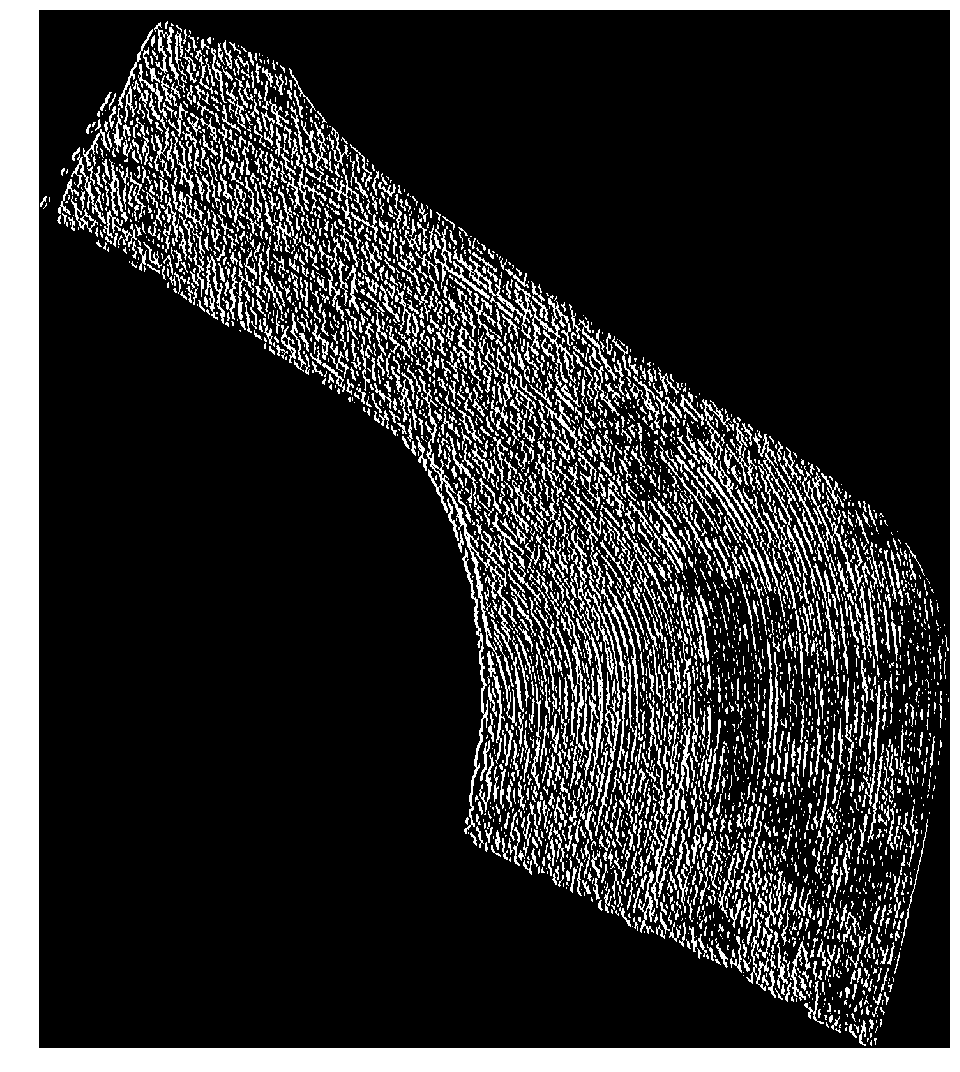

In [12]:
thresh = skimage.filters.threshold_otsu(det)
binary = det > thresh
plot_images([binary])

And eventually overlap it with the initial image.

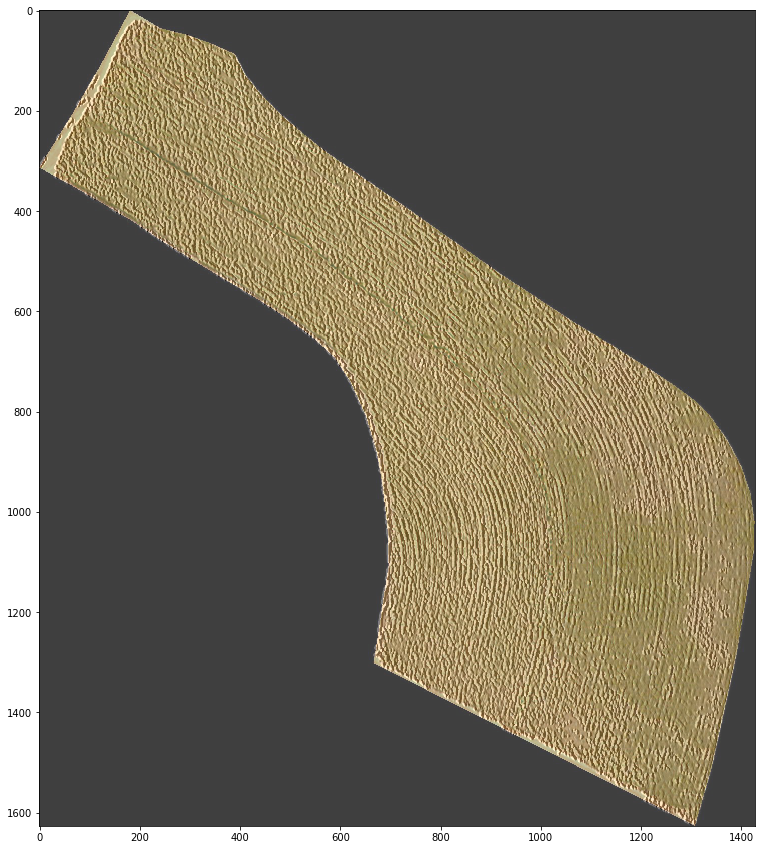

In [30]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(orig)
_ = plt.imshow(det, alpha=0.5, cmap="gray")

Finally, I tried to apply a probabilistic hough transform to extract vectors from the image. However I couldn't get good results because Hough transform extracts only straight lines and couldn't cope with the bended lines of the figure. 

To apply the ough transform I would need to rectify the figure first with a warping trasformation... but that feels like a different exercise :). 

So I decided to split the image in two pieces along the vertical axis, and apply hough to each one separately.

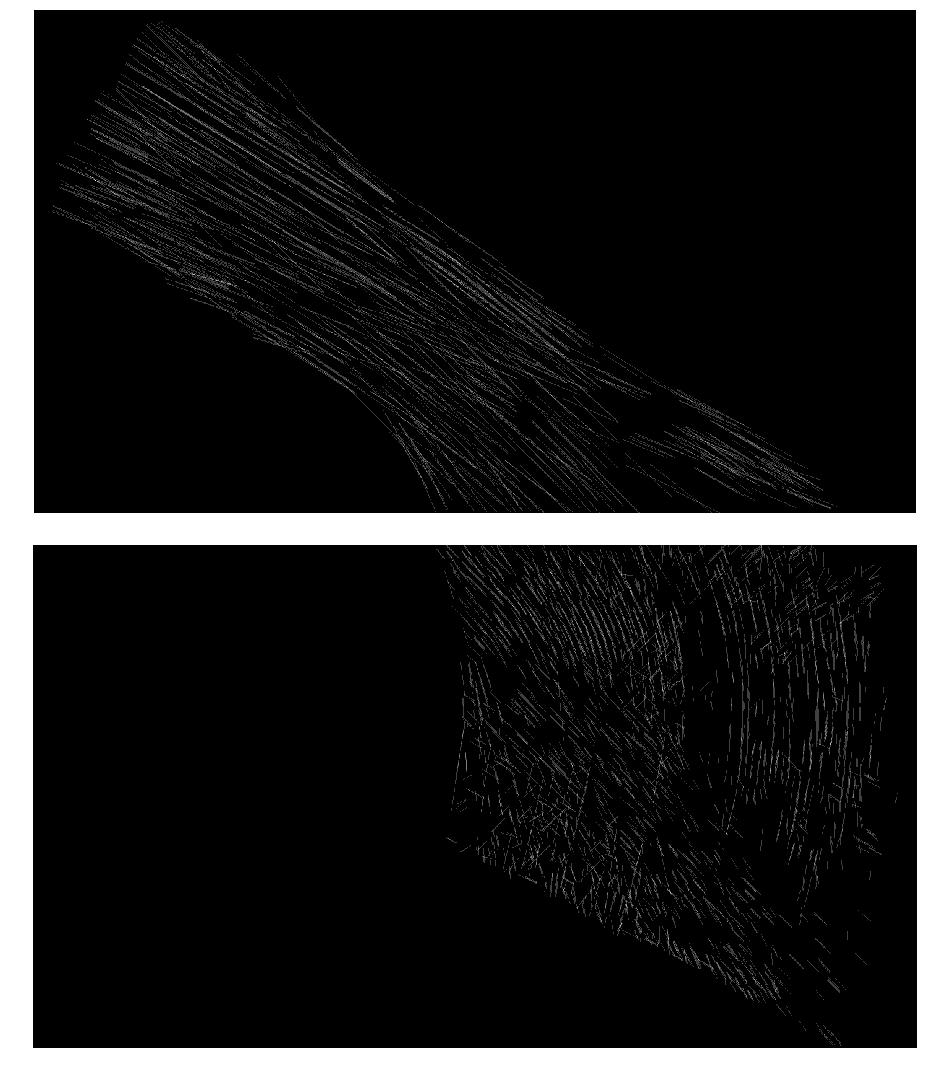

In [12]:
def trace_lines(edges, pars):
    buf = []
    for edge, d in zip(edges, pars):
        # Trace lines
        lines = probabilistic_hough_line(
            edge, threshold=d["th"], line_length=d["ll"], line_gap=d["lg"]
        )

        # Plot vectors
        linesimg = np.zeros_like(edge, dtype=np.uint8)
        for p0, p1 in lines:
            rr, cc = draw.line(p0[1], p0[0], p1[1], p1[0])
            linesimg[rr, cc] += 1
        buf.append(linesimg)
    return buf


splitted = np.array_split(binary, 2, axis=0)
lines = trace_lines(
    splitted,
    pars=[{"th": 50, "ll": 70, "lg": 7}, {"th": 60, "ll": 15, "lg": 3}],
)
plot_images(lines, n_rows=2)